# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp'
syn_data_type = 'timegan_gru'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

In [6]:
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,341988.000000,341988.000000,341988.000000,3.419880e+05,341988.000000
mean,3145.712032,282.708035,0.050878,3.029690e-04,43.593436
std,1957.289369,11.932950,0.231161,6.406578e-04,38.827764
min,82.072840,247.054895,0.000000,0.000000e+00,0.125080
25%,1085.928718,272.528612,0.000005,4.559755e-08,3.629832
50%,3456.190720,284.139969,0.000045,4.407763e-07,29.905888
75%,4970.458088,293.249065,0.008492,2.847757e-04,87.636451
max,7044.640808,307.390251,6.059947,2.400404e-02,95.127577


In [7]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Train and Test Baseline Model

### Set Hyperparameters and Features

In [8]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [9]:
results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.0726222913712263
Training Loss: 0.06399272920563817
Training Loss: 0.06286597192287445
Validation Loss: 0.05734322655401873
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06080565739423036
Training Loss: 0.05597404569387436
Training Loss: 0.054997502993792295
Validation Loss: 0.04911345745740312
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05137727191671729
Training Loss: 0.04610588038340211
Training Loss: 0.04407584886066616
Validation Loss: 0.03784931323417787
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03897133628837764
Training Loss: 0.03407906952314079
Training Loss: 0.03167332640849054
Validation Loss: 0.02559007876918892
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.026588535364717246
Training Loss: 0.02295405121985823
Training Los

/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/data_evaluation/predictive_evaluation.py:247: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:35<32:21, 215.67s/it]

Training Loss: 0.005234427721006796
Validation Loss: 0.0026867851180683694
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5128456154465675
Training Loss: 0.4211130540072918
Training Loss: 0.3275601202994585
Validation Loss: 0.16632016990961654
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.16994774471968413
Training Loss: 0.1077361904270947
Training Loss: 0.08688450401648878
Validation Loss: 0.07556130017122525
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07947029732167721
Training Loss: 0.0734423558972776
Training Loss: 0.07398208094760776
Validation Loss: 0.07259738700610868
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07325566301122308
Training Loss: 0.06808260692283512
Training Loss: 0.06866432536393403
Validation Loss: 0.06767626106739044
Validation Accuracy: 0

 20%|██        | 2/10 [07:12<28:50, 216.32s/it]

Training Loss: 0.005256309168762527
Validation Loss: 0.0027625039756151563
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.9277152815461158
Training Loss: 0.7723961585760116
Training Loss: 0.6178648865222931
Validation Loss: 0.4024284475305107
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3582510494440794
Training Loss: 0.20679228097200394
Training Loss: 0.11535732034593821
Validation Loss: 0.06772976351922817
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07531839180737734
Training Loss: 0.06777094857767224
Training Loss: 0.06757901828736067
Validation Loss: 0.06351817667149426
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06648549797013402
Training Loss: 0.061504474841058254
Training Loss: 0.061204180475324395
Validation Loss: 0.05731289109654641
Validation Accuracy:

 30%|███       | 3/10 [10:50<25:19, 217.04s/it]

Training Loss: 0.005785094380844385
Validation Loss: 0.0029445320179455736
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6928148777782916
Training Loss: 0.54735412850976
Training Loss: 0.3982155287265778
Validation Loss: 0.2116095550944296
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.17931699458509684
Training Loss: 0.0975915202870965
Training Loss: 0.07232847345992922
Validation Loss: 0.05667988007909126
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06561369070783257
Training Loss: 0.061546858474612234
Training Loss: 0.0607967490516603
Validation Loss: 0.05241595175159111
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05899909362196922
Training Loss: 0.055339884888380764
Training Loss: 0.054870274886488914
Validation Loss: 0.04831461271459467
Validation Accuracy: 0

 40%|████      | 4/10 [14:27<21:43, 217.22s/it]

Training Loss: 0.006192347473697737
Validation Loss: 0.0034162017773167134
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5361555518209934
Training Loss: 0.3687069437652826
Training Loss: 0.19266404125839473
Validation Loss: 0.05770101059186325
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07032708954066039
Training Loss: 0.058905018707737324
Training Loss: 0.05590337078087032
Validation Loss: 0.048175232673294086
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.052010367829352616
Training Loss: 0.04766356382519007
Training Loss: 0.04639518297277391
Validation Loss: 0.04235469152250986
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04395953952334821
Training Loss: 0.04043371695093811
Training Loss: 0.039627060033380984
Validation Loss: 0.03697028894270404
Validation Accu

 50%|█████     | 5/10 [18:05<18:06, 217.39s/it]

Training Loss: 0.005929596530040726
Validation Loss: 0.0032745046407674974
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1237894356623292
Training Loss: 0.09810688432306051
Training Loss: 0.08921557508409023
Validation Loss: 0.08166982786039288
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08234567016363144
Training Loss: 0.07529856333509087
Training Loss: 0.07450687110424042
Validation Loss: 0.06950502654307344
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07241255616769195
Training Loss: 0.0666455315798521
Training Loss: 0.06574745180085301
Validation Loss: 0.06008063198140498
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06255469961091877
Training Loss: 0.05670729054138064
Training Loss: 0.05518145589157939
Validation Loss: 0.04948752438335606
Validation Accuracy

 60%|██████    | 6/10 [21:43<14:29, 217.49s/it]

Training Loss: 0.006132745958748274
Validation Loss: 0.003464414118108957
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3145389574766159
Training Loss: 0.22221731573343276
Training Loss: 0.14158632166683674
Validation Loss: 0.08542873145321782
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.061373908445239066
Training Loss: 0.046804987490177155
Training Loss: 0.04567002327181399
Validation Loss: 0.04164585196988636
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.043293149825185534
Training Loss: 0.039251618767157194
Training Loss: 0.038464580262079835
Validation Loss: 0.03439997588650564
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.035455066431313756
Training Loss: 0.031627063993364575
Training Loss: 0.030606910083442927
Validation Loss: 0.02676585502922535
Validation 

 70%|███████   | 7/10 [25:21<10:52, 217.64s/it]

Training Loss: 0.005548910816432908
Validation Loss: 0.002926502048477447
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07234484490007162
Training Loss: 0.06671966280788183
Training Loss: 0.06591924190521241
Validation Loss: 0.06075456562671769
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06295056587085128
Training Loss: 0.057238993085920814
Training Loss: 0.05572349490597844
Validation Loss: 0.05011723062881593
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05150675505399704
Training Loss: 0.04593229290097952
Training Loss: 0.044074424570426346
Validation Loss: 0.03873527905997935
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03968233364634216
Training Loss: 0.03510395168326795
Training Loss: 0.033647033600136635
Validation Loss: 0.029157797805964947
Validation Acc

 80%|████████  | 8/10 [28:58<07:15, 217.55s/it]

Training Loss: 0.005574345455388538
Validation Loss: 0.0029569623358756975
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6298170164227486
Training Loss: 0.5219274085760116
Training Loss: 0.40799538016319276
Validation Loss: 0.2616115684589643
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.2048463259637356
Training Loss: 0.11335851956158877
Training Loss: 0.08089837865903973
Validation Loss: 0.06715842876374052
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0693728948943317
Training Loss: 0.06455154357478023
Training Loss: 0.06542759155854583
Validation Loss: 0.06319091067220388
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06576599605381489
Training Loss: 0.06189596110954881
Training Loss: 0.0626143754646182
Validation Loss: 0.060186005500930076
Validation Accuracy: 0

 90%|█████████ | 9/10 [32:35<03:37, 217.33s/it]

Training Loss: 0.006136450064368546
Validation Loss: 0.0034371233254859453
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3041873299330473
Training Loss: 0.22798251748085022
Training Loss: 0.1676137113198638
Validation Loss: 0.1309100618020872
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10430600967258215
Training Loss: 0.08362209150567651
Training Loss: 0.07578015845268965
Validation Loss: 0.06558229924922579
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0694187587313354
Training Loss: 0.0649736594222486
Training Loss: 0.06361078541725874
Validation Loss: 0.056516561406047154
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06103548189625144
Training Loss: 0.05723013503476977
Training Loss: 0.05635938171297312
Validation Loss: 0.05076296711235904
Validation Accuracy: 

100%|██████████| 10/10 [36:11<00:00, 217.19s/it]

Training Loss: 0.00590203678002581
Validation Loss: 0.0034676361070380786
Validation Accuracy: 0.0
**************************************************


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.09597215613350273
Training Loss: 0.07883028218522668
Training Loss: 0.07215588258579374
Validation Loss: 0.06954615707561541
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0674761507101357
Training Loss: 0.06440615292638541
Training Loss: 0.06234079834073782
Validation Loss: 0.06124754917671841
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05963315671309829
Training Loss: 0.05686042480170727
Training Loss: 0.054491729857400056
Validation Loss: 0.05282506206480975
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05108968650922179
Training Loss: 0.048041484830901024
Training Loss: 0.04532230095006526
Validation Loss: 0.043200738979189586
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04145045098848641
Training Loss: 0.0385026999656111
Training Los

 10%|█         | 1/10 [03:42<33:21, 222.36s/it]

Validation Loss: 0.003689213279174285
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6523594133555889
Training Loss: 0.505338979959488
Training Loss: 0.3550470627844334
Validation Loss: 0.19540246521656432
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1444641914963722
Training Loss: 0.08832903306931257
Training Loss: 0.07427764123305679
Validation Loss: 0.07234937549055961
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07062100138515234
Training Loss: 0.06834067679941654
Training Loss: 0.06752140088006854
Validation Loss: 0.06871927064958583
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06725491151213646
Training Loss: 0.06517568908631802
Training Loss: 0.06420450780540704
Validation Loss: 0.06508712594010187
Validation Accuracy: 0.0
**********************************

 20%|██        | 2/10 [07:25<29:42, 222.82s/it]

Validation Loss: 0.0040695749575094305
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09143321793526411
Training Loss: 0.08305878410115838
Training Loss: 0.08031836867332459
Validation Loss: 0.07940774350270127
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0769812367297709
Training Loss: 0.07373590745031834
Training Loss: 0.07082535646855831
Validation Loss: 0.06803153235507145
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06511044971644879
Training Loss: 0.05989860551431775
Training Loss: 0.055320718865841625
Validation Loss: 0.05083253827950593
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.048605544166639446
Training Loss: 0.0437932918407023
Training Loss: 0.03937691001687199
Validation Loss: 0.034395320330526724
Validation Accuracy: 0.0
***************************

 30%|███       | 3/10 [11:11<26:11, 224.49s/it]

Validation Loss: 0.00374205578759501
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.828120573759079
Training Loss: 0.7144054594635963
Training Loss: 0.6107700106501579
Validation Loss: 0.5054995995224192
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.4555631163716316
Training Loss: 0.3494811932742596
Training Loss: 0.2501753687113524
Validation Loss: 0.148217225970512
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.11442611485719681
Training Loss: 0.07861172892153263
Training Loss: 0.06898050032556056
Validation Loss: 0.06711102327269115
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06579135144129396
Training Loss: 0.0640420169197023
Training Loss: 0.06343438250944018
Validation Loss: 0.06376871188286315
Validation Accuracy: 0.0
*****************************************

 40%|████      | 4/10 [14:55<22:24, 224.05s/it]

Validation Loss: 0.0032203881680871243
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 1.1126206931471825
Training Loss: 0.8610554873943329
Training Loss: 0.6490941722691059
Validation Loss: 0.3986342628015561
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.2947892825305462
Training Loss: 0.1326355707272887
Training Loss: 0.07439015414565801
Validation Loss: 0.05913694338935815
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.056315596252679824
Training Loss: 0.05376352683641016
Training Loss: 0.053071729112416505
Validation Loss: 0.05413229807457897
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05223381917923689
Training Loss: 0.051081622568890456
Training Loss: 0.05029101932421327
Validation Loss: 0.051105252749631916
Validation Accuracy: 0.0
******************************

 50%|█████     | 5/10 [18:41<18:44, 224.82s/it]

Validation Loss: 0.004250403983502785
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0644328487291932
Training Loss: 0.05975249642506242
Training Loss: 0.05553776381537318
Validation Loss: 0.05223215664370676
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04958559921942651
Training Loss: 0.0451686108391732
Training Loss: 0.04086080377921462
Validation Loss: 0.03742796494468544
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.035267134830355644
Training Loss: 0.031903306152671576
Training Loss: 0.028485027155838907
Validation Loss: 0.025378985963552522
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.024167403406463565
Training Loss: 0.021994782048277556
Training Loss: 0.019703160838689657
Validation Loss: 0.017910511217216093
Validation Accuracy: 0.0
***********************

 60%|██████    | 6/10 [22:25<14:58, 224.52s/it]

Validation Loss: 0.0035072278154208167
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.19586191188544036
Training Loss: 0.1491223368421197
Training Loss: 0.11581780608743429
Validation Loss: 0.09178802513339546
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0828996154293418
Training Loss: 0.07473716279491782
Training Loss: 0.07079321093857288
Validation Loss: 0.06790286463716727
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06551117530092597
Training Loss: 0.061769659128040076
Training Loss: 0.058906182777136565
Validation Loss: 0.057141613801208774
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05524266342632472
Training Loss: 0.05235231533646584
Training Loss: 0.04982910979539156
Validation Loss: 0.04814866530510147
Validation Accuracy: 0.0
***************************

 70%|███████   | 7/10 [26:11<11:15, 225.16s/it]

Validation Loss: 0.0029398489964529454
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09799530217424035
Training Loss: 0.08298407789319753
Training Loss: 0.07670688707381487
Validation Loss: 0.07379636777502098
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0719358142465353
Training Loss: 0.06951927838847041
Training Loss: 0.06789602054283023
Validation Loss: 0.06600347784965226
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06437418648973108
Training Loss: 0.060980966947972774
Training Loss: 0.057968794591724875
Validation Loss: 0.0542043029968993
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05243683524429798
Training Loss: 0.04824937398545444
Training Loss: 0.04480788327753544
Validation Loss: 0.04073513503280583
Validation Accuracy: 0.0
****************************

 80%|████████  | 8/10 [29:57<07:30, 225.44s/it]

Validation Loss: 0.0032885555920892217
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.575732027888298
Training Loss: 0.4371508629620075
Training Loss: 0.3165339210629463
Validation Loss: 0.19694566115569534
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1510110379382968
Training Loss: 0.0959941822849214
Training Loss: 0.07761457784101367
Validation Loss: 0.072495630659749
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06992420352995396
Training Loss: 0.0667756443656981
Training Loss: 0.06606012631207704
Validation Loss: 0.06718723494768812
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06569129254668951
Training Loss: 0.06324426375329495
Training Loss: 0.06213574515655637
Validation Loss: 0.06271845098124461
Validation Accuracy: 0.0
*************************************

 90%|█████████ | 9/10 [33:48<03:47, 227.05s/it]

Validation Loss: 0.0035314903695272343
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6693640437722206
Training Loss: 0.484476902782917
Training Loss: 0.32163023702800275
Validation Loss: 0.17814184013712273
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.13729280944913624
Training Loss: 0.09028838058933615
Training Loss: 0.0761890922486782
Validation Loss: 0.07150761257815227
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06912786807864904
Training Loss: 0.06579690692946315
Training Loss: 0.0644175717420876
Validation Loss: 0.06351852594885264
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.061973542999476196
Training Loss: 0.058608656749129295
Training Loss: 0.05669172028079629
Validation Loss: 0.05477586461838042
Validation Accuracy: 0.0
*******************************

100%|██████████| 10/10 [37:42<00:00, 226.26s/it]


Validation Loss: 0.004195029206385606
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.47326200813055036
Training Loss: 0.3451999204605818
Training Loss: 0.24854238234460355
Validation Loss: 0.15561884953822502
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12314043380320072
Training Loss: 0.0791989816352725
Training Loss: 0.06540172632783652
Validation Loss: 0.060687881400132315
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058976844884455204
Training Loss: 0.0563563572242856
Training Loss: 0.05463050412014127
Validation Loss: 0.0531166858513262
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05175182168371975
Training Loss: 0.04862685865722596
Training Loss: 0.04672602536156774
Validation Loss: 0.04495345407774329
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.043823429150506854
Training Loss: 0.040349363964051005
Training Loss

In [ ]:
results.shape

(80, 3)

In [ ]:
results.to_csv(DATA_FOLDER / f"results/results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}.csv", index=False)

In [ ]:
mse_results = results.loc[results['Metric'] == 'MSE']
mae_results = results.loc[results['Metric'] == 'MAE']

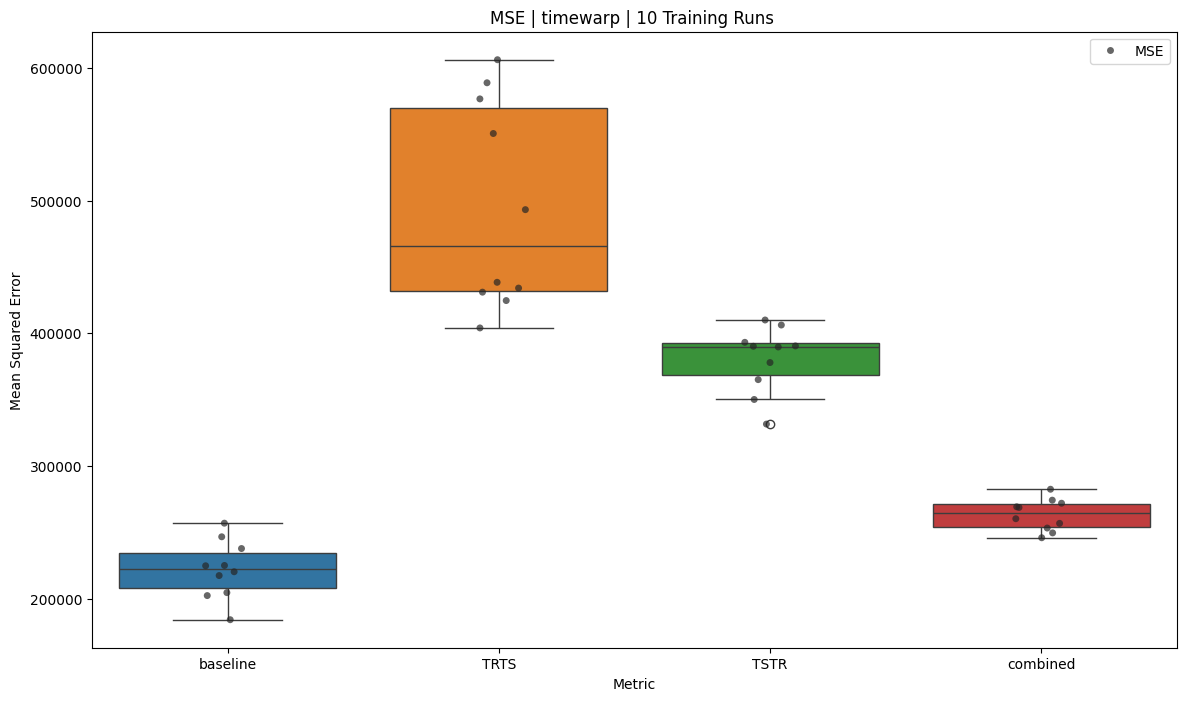

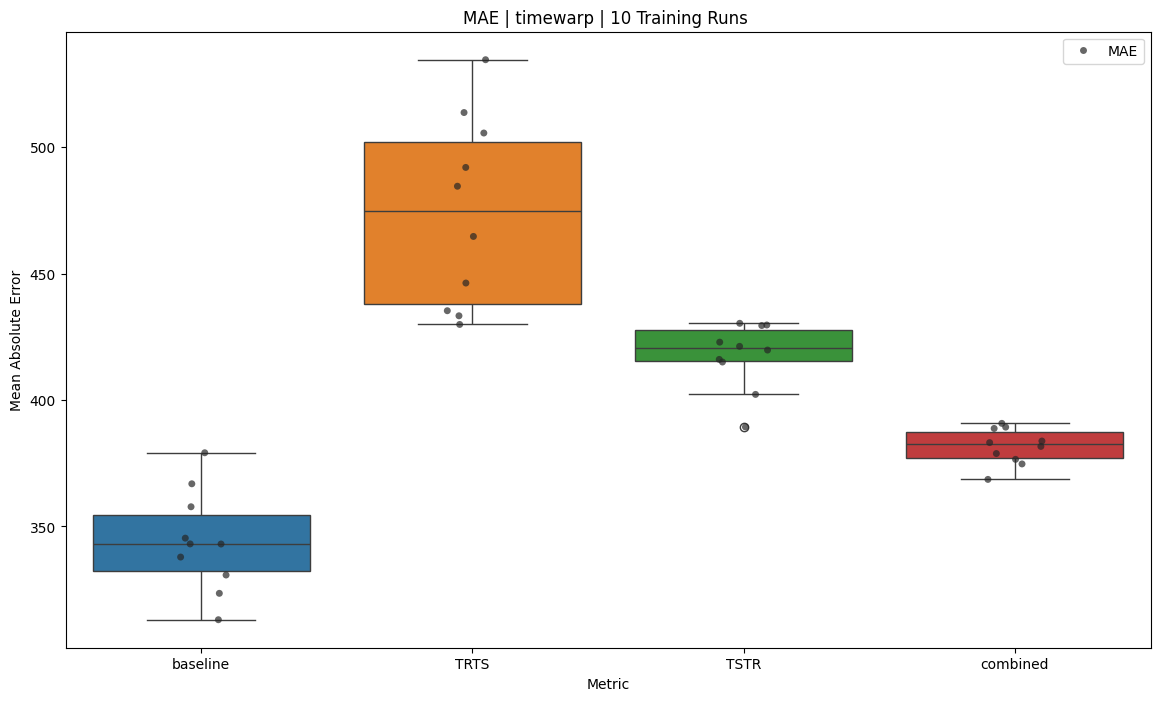

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

## 3 Visualize Synthetic vs Real Data

In [ ]:
# split data before feeding into visual evaluation
data_real_seq = split_data_into_sequences(data_real_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

if data_syn_numpy.ndim == 3:
    data_syn_seq = data_syn_numpy
else:
    data_syn_seq = split_data_into_sequences(data_syn_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

Shape of the data after splitting into sequences: (28500, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)


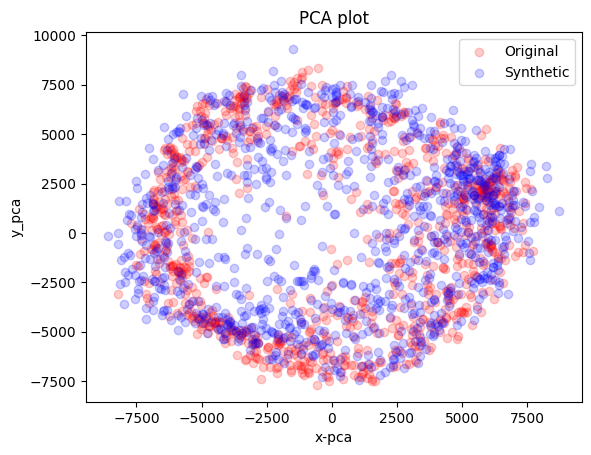

Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.189s...


/Users/arneallwardt/Documents/-Studium/Bachelorarbeit/time_series_data_augmentation/time_series_data_augmentation_venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1207.028792
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.769028
[t-SNE] KL divergence after 300 iterations: 1.070423


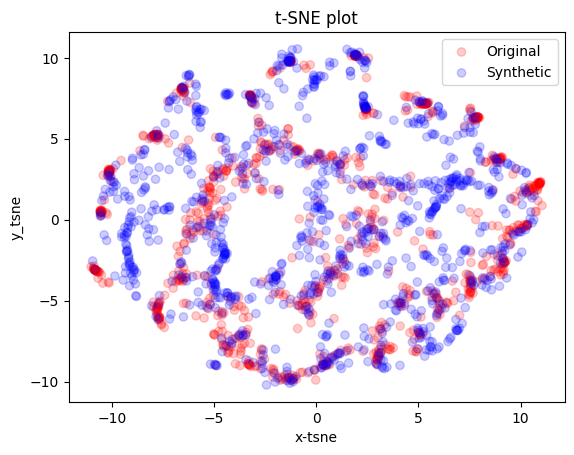

In [ ]:
visualize(data_real_seq, data_syn_seq, metric='pca')
visualize(data_real_seq, data_syn_seq, metric='tsne')

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.